MIT License

Copyright (c) 2024 Mohannad Shehadeh

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

This notebook provides a [Julia](https://julialang.org/) model for a complete encoder/decoder pair for unterminated [Generalized Staircase Codes](https://doi.org/10.1364/OFC.2024.W4C.2) with extended Hamming component codes. These are a special case of [Higher-Order Staircase Codes](https://arxiv.org/pdf/2312.13415). For fast simulation, you should instead use [decsim-gsc](https://github.com/fkschischang/decsim) which is intended to simulate a mathematically equivalent process, but is several orders of magnitude faster. I try to use similar variable names to [decsim-gsc](https://github.com/fkschischang/decsim) to help with understanding both.

In [1]:
# Install required packages as needed
using DataStructures
using Dates
using Plots

In [2]:
include("GF2-LinAlg.jl");

In [3]:
# Sidelength and degree parameter. Bit degree is M + 1.
# You must choose M to be less than or equal to the least prime factor of S
# to get a proper generalized staircase code with the right error floor performance.
S = 11
M = 2

# Golomb rulers of arbitrary order are supported by defining them
# here as needed
if M == 1
    GOLOMB = [0 1]
    MEMORY = 1
elseif M == 2
    GOLOMB = [0 1 3]
    MEMORY = 3
elseif M == 3
    GOLOMB = [0 1 4 6]
    MEMORY = 6
elseif M == 4
    GOLOMB = [0 1 4 9 11]
    MEMORY = 11
else
    throw("M value not supported; add more Golomb rulers!")
end

# Decoding window size in number of S x S blocks
W = 6

# Number of decoding iterations
ITERS = 4

m = ceil(Int64, log2(S*(M+1)))
s = 2^m - (M+1)S;
n = (M+1)S;
k = n-(m+1);
@assert m+1 <= S
@assert W >= 1+MEMORY
println("S = $S, M = $M, W = $W, MEMORY = $MEMORY")
println("rate = $(1-(m+1)/S)")
println("component code dimension/length k/n = $k/$n")
println("number of parity bits (or parity columns in a block) m+1 = $(m+1)")

S = 11, M = 2, W = 6, MEMORY = 3
rate = 0.36363636363636365
component code dimension/length k/n = 26/33
number of parity bits (or parity columns in a block) m+1 = 7


In [4]:
# The following creates a systematic extended Hamming code 
# generator matrix G, parity-check matrix H, its transpose Ht,
# and the parity/non-identity portion of the generator matrix P
# This is a special choice of systematic extended Hamming code
# with a LUT-free decoding method described in the Higher-Order
# Staircase Codes paper.

# m a b ainv
special_eHamming = 
[
3 1 1 1;  
4 3 0  11;
5 3 0  11;
6 3 3  43;
7 5 5  77;
8 9 11  57;
9 19 19  27;
10 27 27  531;
11 53 53  541;
12 89 89  2025;
13 163 170  4875;
14 301 308  13989;
15 553 553  14873;
16 1065 1155 55321;
]
if (m < 3 || m > 16)
    throw("Unsupported m!")
end
a = special_eHamming[m-3+1,2]
b = special_eHamming[m-3+1,3] + a*s
ainv = special_eHamming[m-3+1,4]
mask = (1<<m)-1
minus_b = (1<<m)-b

synFromErrorloc(x) = (((a*x+b)&mask)<<1)+1
errorlocFromSyn(x) = (ainv*((x>>1)+minus_b))&mask

H = zeros(Int64,m+1,0)
for i in 0:n-1
    H = hcat(H,reverse(digits(synFromErrorloc(i),base=2,pad=m+1))) 
end

@assert [errorlocFromSyn(synFromErrorloc(x)) for x in 0:n-1] == 0:n-1
@assert [synFromErrorloc(errorlocFromSyn(2*x+1)) for x in 0:n-1] == 2 .* (0:n-1) .+ 1

G = RREF(dual(H));

Id_kk = Int64.(ones(k,k)^0)
@assert G[1:k,1:k] == Id_kk;
@assert sum(mod.(G*transpose(H),2)) == 0;
P = G[:,k+1:n];
Ht = transpose(H);

In [5]:
TX_buffer = CircularBuffer{Matrix{Int64}}(W); # TX buffer for error counting
RX_buffer = CircularBuffer{Matrix{Int64}}(W); # Decoder buffer
Syn_buffer = CircularBuffer{Matrix{Int64}}(W); # Decoder buffer
ENC_buffer = CircularBuffer{Matrix{Int64}}(MEMORY); # Encoder buffer

In [6]:
function reset_buffers()
    for i in 1:W
        push!(TX_buffer, zeros(Int64,S,S))
        push!(RX_buffer, zeros(Int64,S,S))
        push!(Syn_buffer, zeros(Int64,S,m+1))
    end
    for i in 1:MEMORY
        push!(ENC_buffer, zeros(Int64,S,S))
    end
end;
reset_buffers();

In [7]:
# π_1(l,i,j) = l == 0 ? i : (j-1)+1;
# π_2(l,i,j) = l == 0 ? j : mod((i-1)+(l-1)*(j-1), S) + 1;
# π_inv_1(l,i,j) = l == 0 ? i : mod(-(l-1)*(i-1) + (j-1), S) + 1;
# π_inv_2(l,i,j) = l == 0 ? j : (i-1) + 1;

π_1(l,i,j) = l == 0 ? i : mod.(-(l-1)*(i-1) + (j-1), S) + 1;
π_2(l,i,j) = l == 0 ? j : mod.((1-(l-1)^2)*(i-1) + (l-1)*(j-1), S) + 1;
π_inv_1(l,i,j) = l == 0 ? i : mod.(-(l-1)*(i-1) + (j-1), S) + 1;
π_inv_2(l,i,j) = l == 0 ? j : mod.((1-(l-1)^2)*(i-1) + (l-1)*(j-1), S) + 1;

In [8]:
Π(l,B) = [B[π_1(l,i,j), π_2(l,i,j)] for i in 1:S, j in 1:S];
Π_inv(l,B) = [B[π_inv_1(l,i,j), π_inv_2(l,i,j)] for i in 1:S, j in 1:S];

In [9]:
TEST_MAT = [j + S*i + 1 for i in 0:S-1, j in 0:S-1];
@assert sum([Π_inv(l,Π(l,TEST_MAT)) == TEST_MAT for l in 0:M]) == M+1
@assert sum([Π(l,Π_inv(l,TEST_MAT)) == TEST_MAT for l in 0:M]) == M+1

In [10]:
# Encode a uniformly random S x S-(m+1) info block, push S x S result to ENC_buffer
function encode()
    B_info = rand(0:1,S,S-(m+1));
    B_parity = B_info*P[k-(S-(m+1)-1):k,:]
    for i in 1:M
        B_parity = B_parity + Π(M+1-i,ENC_buffer[end+1-GOLOMB[M+2-i]])*P[1 + (i-1)*S : S + (i-1)*S,:]
    end
    B = mod.([B_info B_parity],2);
    push!(ENC_buffer, B)
end;

In [11]:
# Push clean copy of newest block in ENC_buffer to TX_buffer
# Push a noisy copy to RX_buffer with crossover probability p
# Push an all zero S x (m+1) block of partial syndromes to Syn_buffer 
function transmit(p) 
    push!(TX_buffer, ENC_buffer[end])
    push!(RX_buffer, ENC_buffer[end] .⊻ (rand(S,S) .<= p))
    push!(Syn_buffer, zeros(Int64,S,m+1))
end;

In [12]:
# Update update M + 1 partial syndromes going as far back as MEMORY from
# the end of the syndrome buffer and completing one syndrome group
function update_Syn()
    for i in 0:M
        Syn_buffer[end-MEMORY+GOLOMB[i+1]] .⊻= mod.(Π(i,RX_buffer[end])*Ht[1 + (M-i)*S : S + (M-i)*S,:], 2)
    end
end;

In [13]:
# count_errors() = sum(TX_buffer[1][:,1:S-(m+1)] .!= RX_buffer[1][:,1:S-(m+1)]);
count_errors() = sum(TX_buffer[1] .!= RX_buffer[1]);

In [14]:
integer_basis = [2^i for i in m:-1:0]';

In [15]:
function flip(block, i, j)
    RX_buffer[block][i,j] ⊻= 1
    for u = M:-1:0
        if block-MEMORY+GOLOMB[u+1] <= 0 
            break;
        end
        i_perm, j_perm = π_inv_1(u,i,j), π_inv_2(u,i,j)
        Syn_buffer[block-MEMORY+GOLOMB[u+1]][i_perm,:] .⊻= Ht[(M-u)*S+j_perm,:] 
    end
end;

In [16]:
function sweep()
    for c in (W-MEMORY):-1:1
        for i in 1:S
            if Syn_buffer[c][i,m+1] != 0 
                errorloc = errorlocFromSyn(integer_basis*Syn_buffer[c][i,:]) + 1;
                if errorloc <= n
                    j = (errorloc-1)%S + 1
                    perm = M - floor(Int64, (errorloc-1)/S)
                    flip(c+MEMORY-GOLOMB[perm+1], π_1(perm, i, j), π_2(perm, i, j))
                end
            end          
        end
    end
end;

In [17]:
# Specify vector ps of crossover probabilities to simulate
# and vector TRIALS of respective numbers of trials for each crossover probability
ps = [2,3,4,5,6,7]*1e-2
TRIALS = Int64(3e6)*ones(Int64,length(ps))
display(ps')
display(TRIALS')

1×6 adjoint(::Vector{Float64}) with eltype Float64:
 0.02  0.03  0.04  0.05  0.06  0.07

1×6 adjoint(::Vector{Int64}) with eltype Int64:
 3000000  3000000  3000000  3000000  3000000  3000000

In [18]:
tot = sum(TRIALS); # Total number of trials for progress tracking
percent_increment = round(Int64,tot/100) == 0 ? 1 : round(Int64,tot/100);

In [19]:
BERs = zeros(length(ps))
err_cts = zeros(Int64,length(ps))
tracker = 0
t_0 = now()
for point in 1:length(ps)
    reset_buffers();
    for trial in 1:TRIALS[point]   
        tracker += 1
        if tracker%percent_increment == 0
            percentage = round(Int64,tracker/tot*100)
            if percentage%1 == 0
                println("Progress: $percentage%")
                println("Errors for parameter p = $(ps[point]): $(err_cts[point])")
            end
        end
        encode();
        transmit(ps[point]);
        update_Syn();
        for iter in 1:ITERS
            sweep();
        end
        # Delay of W before starting error counting
        if trial > W
            err_cts[point] += count_errors();
        end     
    end
end
t_1 = now()

Progress: 1%
Errors for parameter p = 0.02: 45
Progress: 2%
Errors for parameter p = 0.02: 106
Progress: 3%
Errors for parameter p = 0.02: 149
Progress: 4%
Errors for parameter p = 0.02: 206
Progress: 5%
Errors for parameter p = 0.02: 260
Progress: 6%
Errors for parameter p = 0.02: 322
Progress: 7%
Errors for parameter p = 0.02: 370
Progress: 8%
Errors for parameter p = 0.02: 418
Progress: 9%
Errors for parameter p = 0.02: 448
Progress: 10%
Errors for parameter p = 0.02: 498
Progress: 11%
Errors for parameter p = 0.02: 546
Progress: 12%
Errors for parameter p = 0.02: 628
Progress: 13%
Errors for parameter p = 0.02: 693
Progress: 14%
Errors for parameter p = 0.02: 766
Progress: 15%
Errors for parameter p = 0.02: 818
Progress: 16%
Errors for parameter p = 0.02: 870
Progress: 17%
Errors for parameter p = 0.03: 402
Progress: 18%
Errors for parameter p = 0.03: 1738
Progress: 19%
Errors for parameter p = 0.03: 3086
Progress: 20%
Errors for parameter p = 0.03: 4408
Progress: 21%
Errors for pa

2024-06-15T17:53:32.253

In [20]:
K = S*(S-(m+1));
println("Simulation duration in different units:")
println(round((t_1 - t_0), Dates.Second(1)))
println(round((t_1 - t_0), Dates.Minute(1)))
println(round((t_1 - t_0), Dates.Hour(1)))
println()
dur_in_ms = (t_1 - t_0).value
dur_in_ms_avg = (dur_in_ms/tot)
println("$tot trials or blocks transmitted")
println("$(tot*K*1e-6) Mbits transmitted")
println("$dur_in_ms_avg milliseconds per trial")
throughput = K/dur_in_ms_avg/1e-3/1e6
println("throughput: $throughput Mbit/s")

Simulation duration in different units:
1660 seconds
28 minutes
0 hours

18000000 trials or blocks transmitted
792.0 Mbits transmitted
0.092205 milliseconds per trial
throughput: 0.47719754893986227 Mbit/s


In [21]:
err_cts'

1×6 adjoint(::Vector{Int64}) with eltype Int64:
 908  22377  302627  2579226  10221850  19786553

In [22]:
# 1.0 ./ ((TRIALS .- W)*K)'

In [23]:
ps'

1×6 adjoint(::Vector{Float64}) with eltype Float64:
 0.02  0.03  0.04  0.05  0.06  0.07

In [24]:
BERs = err_cts ./ ((TRIALS .- W)*K);
BERs'

1×6 adjoint(::Vector{Float64}) with eltype Float64:
 6.8788e-6  0.000169523  0.00229263  0.0195396  0.0774384  0.149898

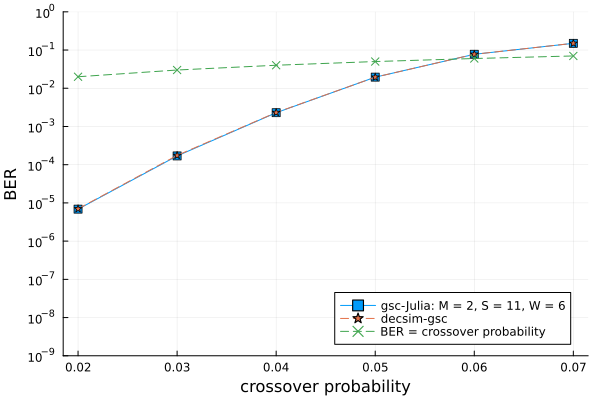

In [25]:
plot(ps, BERs, marker=:rect, yaxis=:log, label="gsc-Julia: M = $M, S = $S, W = $W", legend=:bottomright)
plot!([2,3,4,5,6,7]*1e-2,[7.00759e-06,0.000174925,0.00231948,0.0194574,0.0773971,0.149946],mark=:s,linestyle=:dash,label="decsim-gsc")
plot!(ps,ps,marker=:x,line=:dash,label="BER = crossover probability")
ylims!(1e-9,1e-0)
yticks!([10.0^(-i) for i in 0:9])
ylabel!("BER")
xticks!(ps)
xlabel!("crossover probability")